In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy import integrate, interpolate  
from scipy.stats import gengamma, laplace, norm
from scipy.stats import kstwobign, kstest, ks_1samp, anderson, anderson_ksamp, cramervonmises, kstwo, ksone
from scipy.special import kolmogorov
import matplotlib.pyplot as plt
from utilities import *
%matplotlib inline
import pickle

np.random.seed(42)

In [2]:
data_dict = pd.read_pickle('../data/Toy_Data_Dict_Normalized.pickle')
def rename_cols(df):
    return df.replace({'Orientation' : {'Horizontal detail' : 'H', 'Vertical detail' : 'V', 'Diagonal detail' : 'D'}})

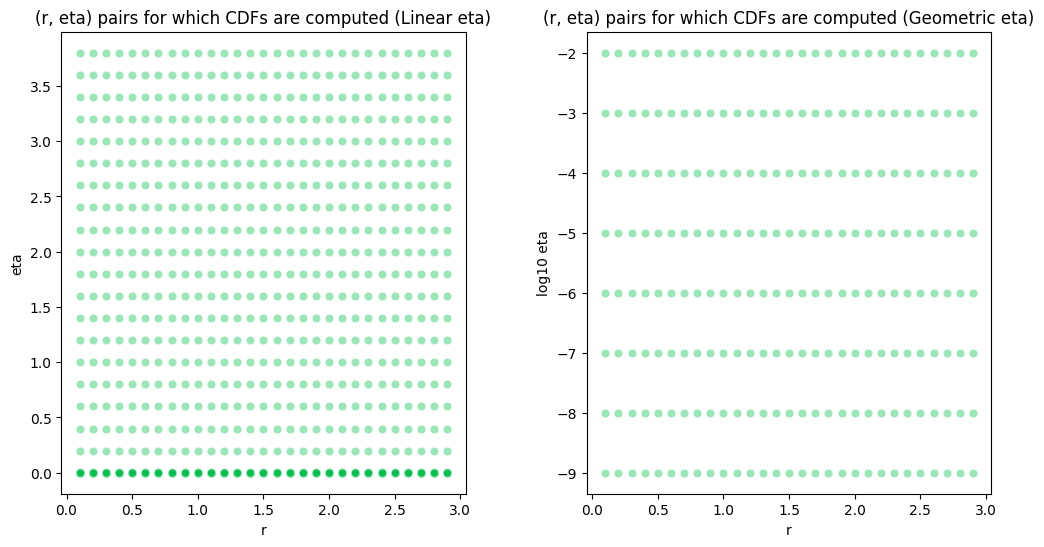

In [3]:
with open('pickles/updated_100000.pickle', 'rb') as handle:
    all_cdfs = pickle.load(handle)
all_cdfs_df = pd.DataFrame({'(r_eta),cdf' : all_cdfs.items()})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r_eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r_eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r_eta),cdf"].str[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 (Linear eta)
sns.scatterplot(x=all_cdfs_df['r'], y=all_cdfs_df['eta'], color='xkcd:shamrock green', alpha=0.4, ax=ax1)
ax1.set_xlabel('r')
ax1.set_ylabel('eta')
ax1.set_title('(r, eta) pairs for which CDFs are computed (Linear eta)')

# Plot 2 (Geometric eta)
mask = all_cdfs_df['eta'].isin(10**np.arange(-9.0, 0))
sns.scatterplot(x=all_cdfs_df['r'], y=np.log10(all_cdfs_df[mask]['eta']), color='xkcd:shamrock green', alpha=0.4, ax=ax2)
ax2.set_xlabel('r')
ax2.set_ylabel(f'log10 eta')
ax2.set_title('(r, eta) pairs for which CDFs are computed (Geometric eta)')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()

In [4]:
def make_layer_df(data_dict, layer, all_cdfs, all_cdfs_df, only_diag = False):
    # Assumes all_cdfs_df and all_cdfs dict exist
    layer = rename_cols(data_dict[layer])
    if only_diag:
        ornt = ['D']
    else:
        ornt = ['H', 'V']
    x = np.array([np.concatenate(layer[layer["Orientation"] == direction]["Flattened Data"].values.flatten()) for direction in ornt]).flatten()
    obs_x = np.sort(x)
    print(f"Number of samples: {x.shape[0]}")
    df = all_cdfs_df.copy()
    kstest_stat_pval = all_cdfs_df.apply(lambda row : kstest_custom(obs_x, all_cdfs[(row.iloc[1], row.iloc[2])]), axis = 1)
    df['kstest_stat'] = kstest_stat_pval.str[0]
    df['kstest_pval'] = kstest_stat_pval.str[1]
    return df, obs_x
    

In [5]:
xs = np.linspace(-100, 100, 10000)
df, obs_x = make_layer_df(data_dict, 5, all_cdfs, all_cdfs_df)

Number of samples: 51328


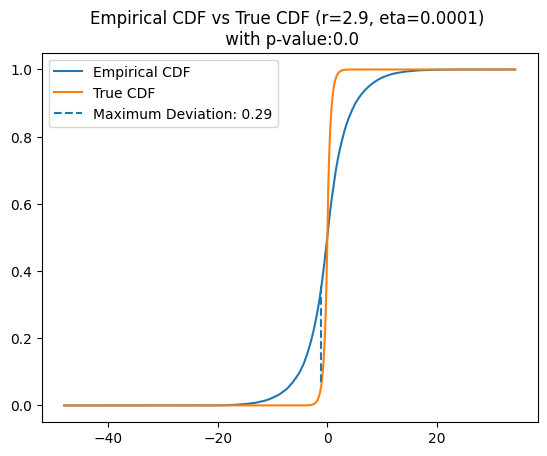

In [6]:
distance, location = visualize_cdfs(obs_x, 2.9, 0.0001, all_cdfs)

In [7]:
def create_scatter_plots(df, metric):
    """
    Create two scatter plots side by side, where the color of each point represents the value from the specified metric column.
    
    Arguments:
    df -- A pandas DataFrame containing the columns 'r', 'eta', and the specified metric column.
    metric -- The name of the column in the DataFrame to use for color mapping.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 1 (Linear eta)
    scatter1 = ax1.scatter(df['r'], df['eta'], c=df[metric], cmap='viridis', alpha=0.8)
    ax1.set_xlabel('r')
    ax1.set_ylabel('eta')
    ax1.set_title('(r, eta) pairs colored by {}'.format(metric))

    cbar1 = fig.colorbar(scatter1, ax=ax1)
    cbar1.set_label(metric)
    
    # Plot 2 (Geometric eta)
    mask = df['eta'].isin(10**np.arange(-9.0, 0))
    scatter2 = ax2.scatter(df[mask]['r'], np.log10(df[mask]['eta']), c=df[mask][metric], cmap='viridis', alpha=0.8)
    ax2.set_xlabel('r')
    ax2.set_ylabel('eta')
    ax2.set_title('(r, eta) pairs colored by {} (Geometric eta)'.format(metric))

    cbar2 = fig.colorbar(scatter2, ax=ax2)
    cbar2.set_label(metric)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

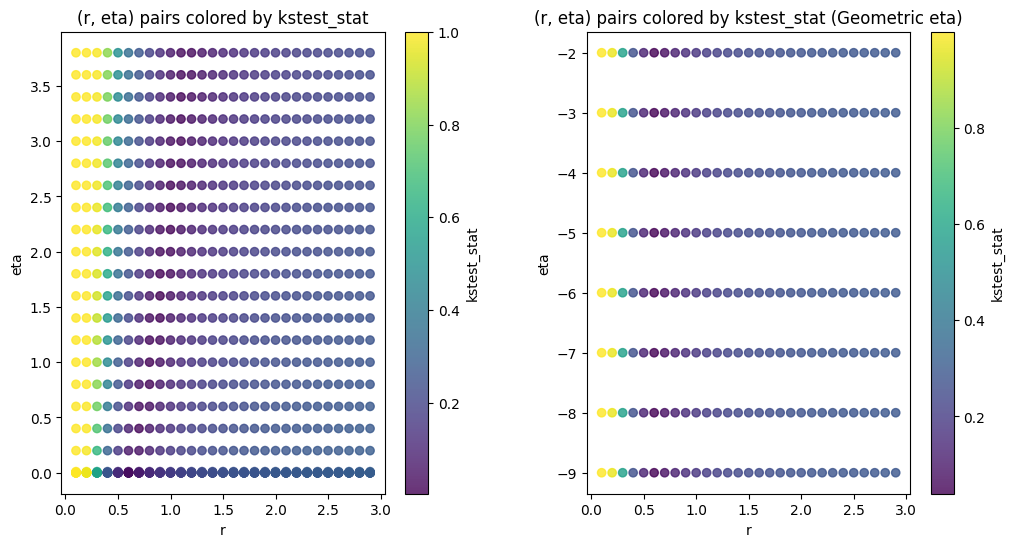

In [68]:
create_scatter_plots(df, 'kstest_stat')

In [9]:
def create_contour_plot(df, metric, log_eta = False):
    """
    Create a contour plot with a semi-transparent heatmap in the background, where the color represents the values from the specified metric column.
    
    Arguments:
    df -- A pandas DataFrame containing the columns 'r', 'eta', and the specified metric column.
    metric -- The name of the column in the DataFrame to use for color mapping.
    """
    
    # Create a meshgrid from r and eta
    r_meshgrid, eta_meshgrid = np.meshgrid(df['r'].unique(), df['eta'].unique())
    
    metric_meshgrid = np.zeros_like(r_meshgrid)
    for i, r in enumerate(df['r'].unique()):
        for j, eta in enumerate(df['eta'].unique()):
            mask = (df['r'] == r) & (df['eta'] == eta)
            if mask.any():
                metric_meshgrid[j, i] = df.loc[mask, metric].values[0]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    heatmap = ax.imshow(metric_meshgrid, extent=[df['r'].min(), df['r'].max(), df['eta'].min(), df['eta'].max()], origin='lower', cmap='viridis', alpha=0.5)
    
    contour = ax.contour(r_meshgrid, eta_meshgrid, metric_meshgrid, cmap='viridis')
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label(metric)
    
    ax.clabel(contour, inline=True, fontsize=10)
    ax.set_xlabel('r')
    ax.set_ylabel('eta')
    ax.set_title('Contour Plot (r, eta) colored by {}'.format(metric))
    
    plt.show()

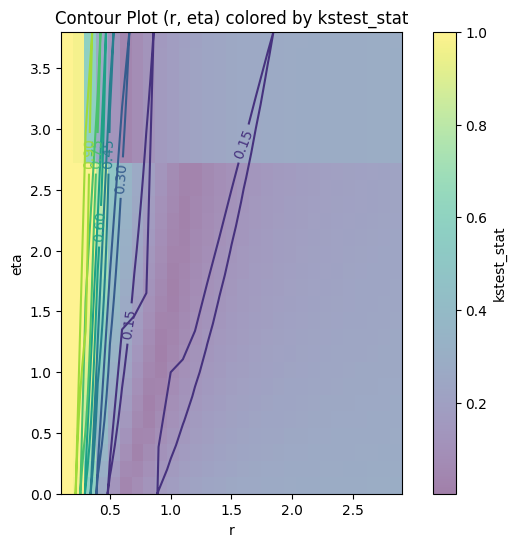

In [10]:
create_contour_plot(df, 'kstest_stat', log_eta = True)

In [12]:
with open('pickles/all_dist_df_full.pickle', 'rb') as handle:
    all_dist_df = pickle.load(handle)
print(all_dist_df.shape)
all_dist_df.head()

(21280, 9)


,base_r,base_eta,r,eta,distance,10,100,1000,10000
0,0.1,0,0.1,0,0.0,1.0,1.0,1.0,1.0
1,0.1,0.8,0.1,0,0.0,1.0,1.0,1.0,1.0
2,0.1,1.6,0.1,0,0.0,1.0,1.0,1.0,1.0
3,0.1,2.4,0.1,0,0.0,1.0,1.0,1.0,1.0
4,0.1,3.2,0.1,0,0.0,1.0,1.0,1.0,1.0


In [15]:
def generate_heatmap_tile(df, metric_func=None, metric_col='metric', r_range=None, eta_range=None):
    """
    Generate a tile of heatmaps for the given metric function or metric column, and ranges of r and eta values.
    
    Args:
        df (pandas.DataFrame): The input dataframe containing columns 'base_r', 'base_eta', 'r', 'eta', and optionally the metric column.
        metric_func (callable, optional): The metric function that takes 'base_r', 'base_eta', 'r', 'eta' as arguments and returns a scalar value.
                                          If the metric column already exists in the dataframe, this argument can be omitted.
        metric_col (str, optional): The name of the column containing the metric values. Default is 'metric'.
        r_range (list or np.ndarray, optional): The range of r values to consider. If None, all unique r values in the dataframe will be used.
        eta_range (list or np.ndarray, optional): The range of eta values to consider. If None, all unique eta values in the dataframe will be used.
        
    Returns:
        matplotlib.figure.Figure: The figure object containing the tile of heatmaps.
    """
    # Check if the metric column exists in the dataframe
    if metric_col not in df.columns:
        # If the metric column doesn't exist, apply the metric function to the dataframe
        if metric_func is None:
            raise ValueError("Either the metric column or the metric function must be provided.")
        df[metric_col] = df.apply(lambda row: metric_func(row['base_r'], row['base_eta'], row['r'], row['eta']), axis=1)
    
    # If r_range or eta_range are not provided, use all unique values in the dataframe
    if r_range is None:
        r_range = sorted(df['r'].unique())
    if eta_range is None:
        eta_range = sorted(df['eta'].unique())
    
    # Sort the r and eta ranges
    base_r_values = sorted(set(df['base_r'].unique()))
    base_eta_values = sorted(set(df['base_eta'].unique()))
    
    # Create a figure with subplots
    fig, axs = plt.subplots(len(base_eta_values), len(base_r_values), figsize=(5*len(base_eta_values), 5*len(base_r_values)))
    
    # Iterate over the subplots and create heatmaps
    for i, base_eta in enumerate(base_eta_values):
        for j, base_r in enumerate(base_r_values):
            ax = axs[i, j]
            
            # Filter the dataframe based on base_r and base_eta
            filtered_df = df.loc[(df['base_r'] == base_r) & (df['base_eta'] == base_eta)]
            
            # Get the three closest values of r and eta for the filtered dataframe
            r_values = filtered_df['r'].unique()[:3]
            eta_values = filtered_df['eta'].unique()[:3]
            
            # Create the heatmap data
            heatmap_data = filtered_df.loc[filtered_df['r'].isin(r_values) & filtered_df['eta'].isin(eta_values)]
            heatmap_data = heatmap_data.pivot_table(index='eta', columns='r', values=metric_col)
            heatmap_data = heatmap_data.reindex(index=eta_values, columns=r_values, fill_value=np.nan)
            
            # Check if the heatmap data is empty
            if heatmap_data.empty:
                ax.set_visible(False)
                continue
            
            # Plot the heatmap
            sns.heatmap(heatmap_data.astype('float'), annot=True, annot_kws={'fontsize': 8}, cmap='viridis', ax=ax, alpha=0.4)
            ax.set_title(f'Base: r={base_r}, eta={base_eta}', fontsize=12)
            ax.set_xlabel('r', fontsize=10)
            ax.set_ylabel('eta', fontsize=10)
            
    # Add a set of axes outside the tiles
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("r", fontsize=14)
    plt.ylabel("eta", fontsize=14)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    return fig

In [14]:
import numpy as np

def kl_divergence(p, q, support):
    """
    Calculates the Kullback-Leibler (KL) divergence between two numerically approximated
    probability density functions (PDFs) p and q.

    Args:
        p (numpy.ndarray): The first PDF approximation.
        q (numpy.ndarray): The second PDF approximation.
        support (numpy.ndarray): The support values (e.g., x-axis values) for the PDFs.

    Returns:
        float: The KL divergence between p and q.
    """
    # Ensure that the PDFs and support have the same length
    assert len(p) == len(q) == len(support), "PDFs and support must have the same length"

    # Compute the KL divergence
    kl_div = 0
    for i in range(len(p)):
        if p[i] > 0 and q[i] > 0:
            kl_div += p[i] * np.log(p[i] / q[i])

    # Approximate the KL divergence by multiplying with the step size
    step_size = support[1] - support[0]
    kl_div *= step_size

    return kl_div

In [46]:
xs, p1 = compute_prior_pdf(1, 0.8)
xs, p2 = compute_prior_pdf(1, 0.001)

In [47]:
kl_divergence(p1/np.sum(p1), p2/np.sum(p2), xs)

1.649122776259967

In [48]:
scipy.stats.entropy(p1, p2, base = 2)

0.11895906255636464

Number of samples: 51328


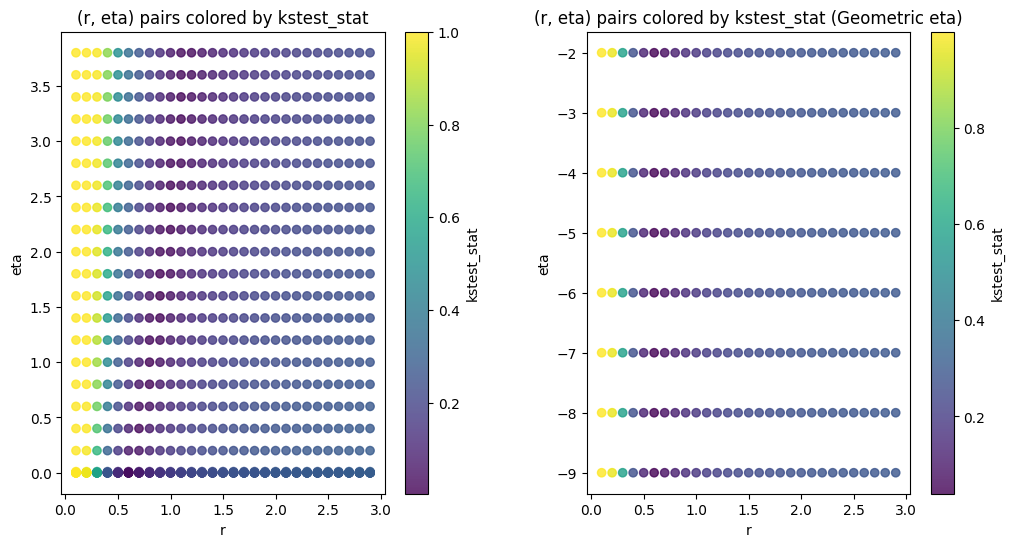

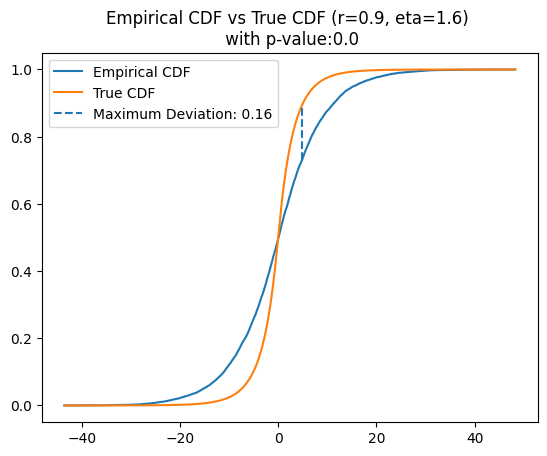

In [72]:
xs = np.linspace(-100, 100, 10000)
df5, obs_x5 = make_layer_df(data_dict, 5, all_cdfs, all_cdfs_df)
create_scatter_plots(df5, 'kstest_stat')
distance, location = visualize_cdfs(obs_x, 0.9, 1.6, all_cdfs)

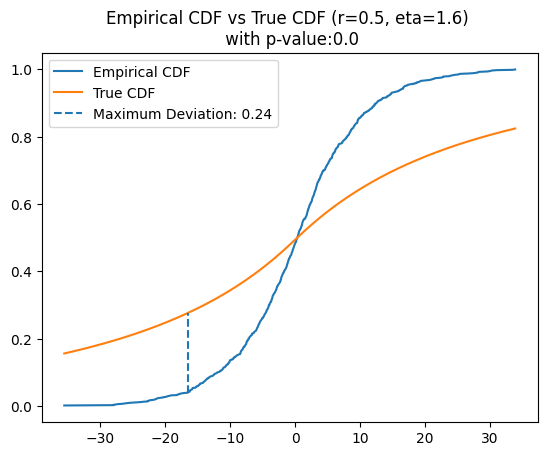

In [92]:
distance, location = visualize_cdfs(obs_x[np.random.permutation(len(obs_x))][:1000], 0.5, 1.6, all_cdfs)

Number of samples: 12832


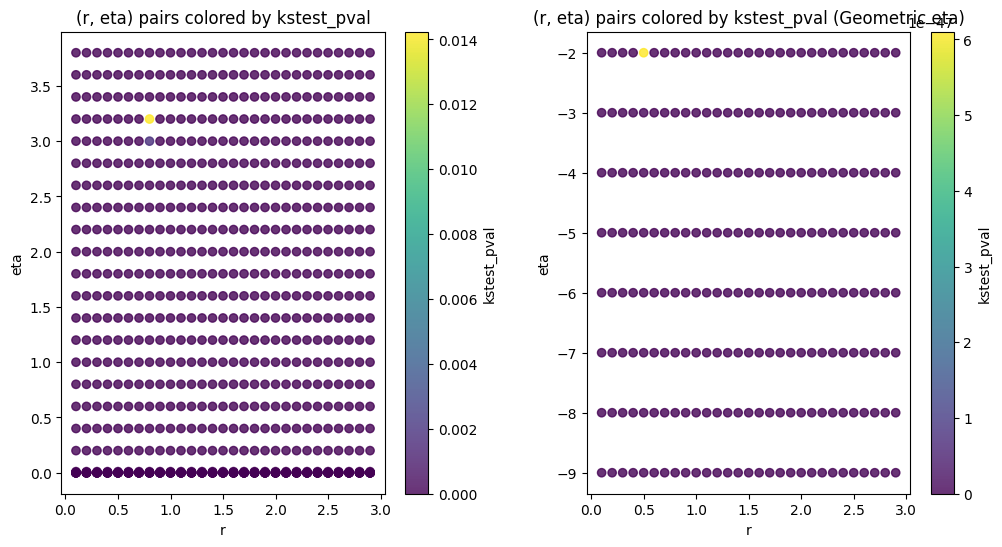

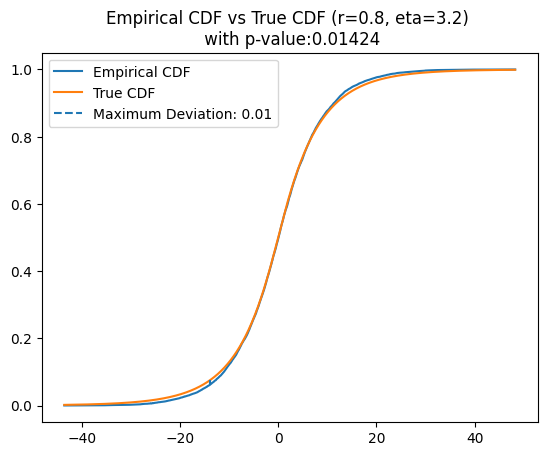

In [59]:
xs = np.linspace(-100, 100, 10000)
df4, obs_x = make_layer_df(data_dict, 4, all_cdfs, all_cdfs_df)
create_scatter_plots(df4, 'kstest_pval')
distance, location = visualize_cdfs(obs_x, 0.8, 3.2, all_cdfs)

Number of samples: 205312


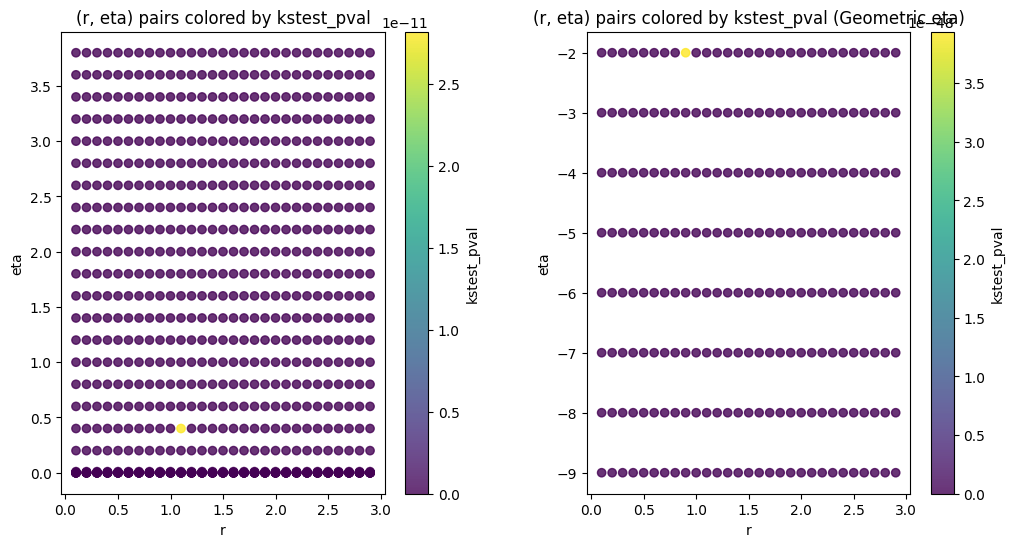

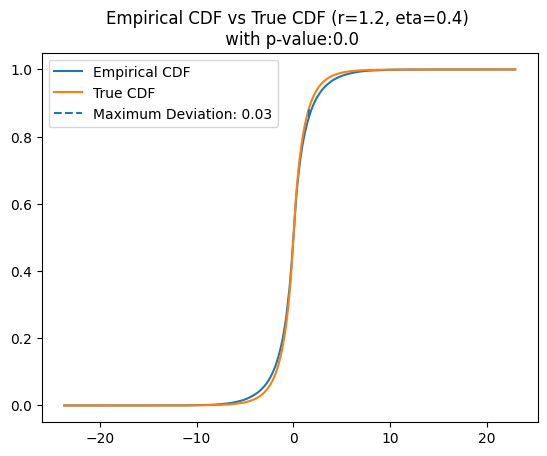

In [61]:
xs = np.linspace(-100, 100, 10000)
df6, obs_x6 = make_layer_df(data_dict, 6, all_cdfs, all_cdfs_df)
create_scatter_plots(df6, 'kstest_pval')
distance, location = visualize_cdfs(obs_x6, 1.2, 0.4, all_cdfs)

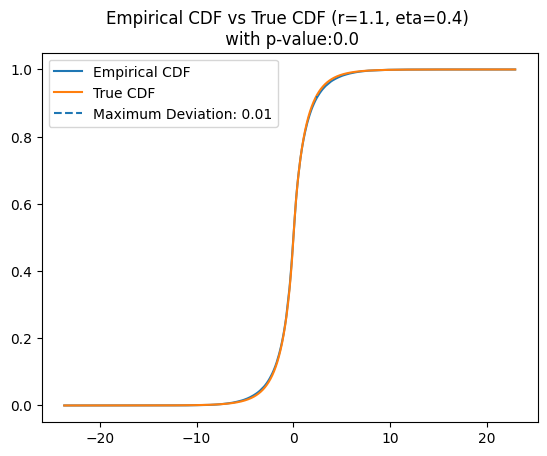

In [67]:
distance, location = visualize_cdfs(obs_x6, 1.1, 0.4, all_cdfs)

Number of samples: 821248


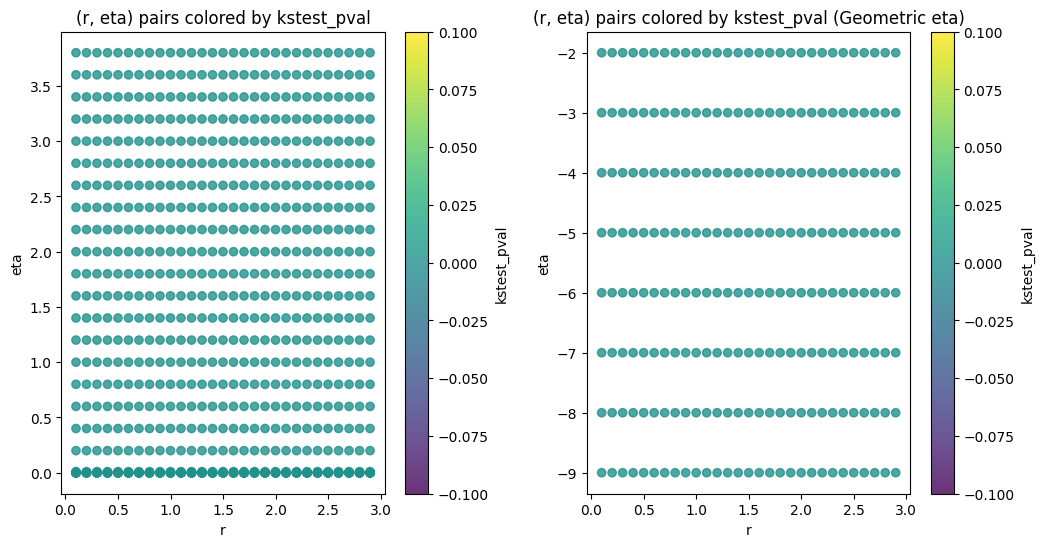

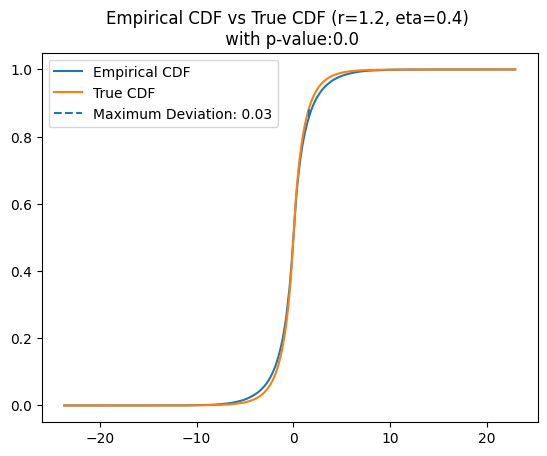

In [62]:
xs = np.linspace(-100, 100, 10000)
df7, obs_x7 = make_layer_df(data_dict, 7, all_cdfs, all_cdfs_df)
create_scatter_plots(df7, 'kstest_pval')
distance, location = visualize_cdfs(obs_x6, 1.2, 0.4, all_cdfs)

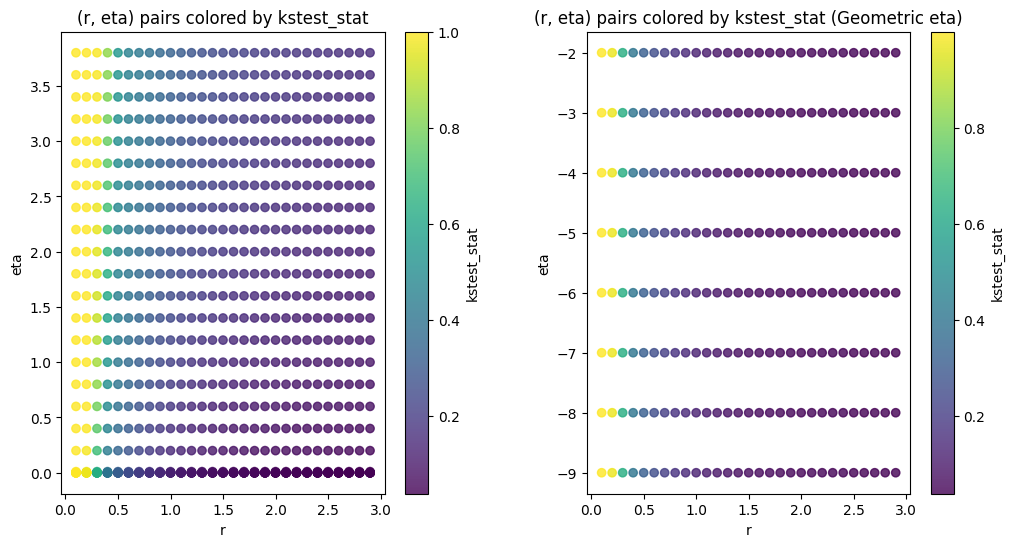

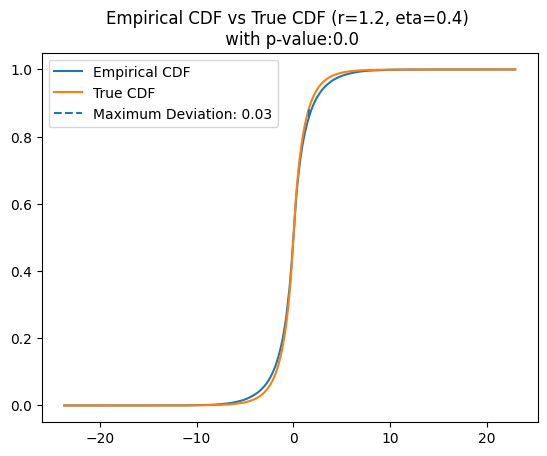

In [93]:
create_scatter_plots(df7, 'kstest_stat')
distance, location = visualize_cdfs(obs_x6, 1.2, 0.4, all_cdfs)